# Random Forest Decision Tree Collapsing

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

np.random.seed(0)

In [2]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset

In [3]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Remove setosa flowers as am only interested in true or false

In [4]:
df = df[df["species"] != "setosa"]
species = df["species"]

Drop sepal length and width, as well as species, so there are only two categories.

In [5]:
df = df.drop(["species", "sepal length (cm)", "sepal width (cm)"], axis=1)

In [6]:
print(set(species))
df.head()

{'versicolor', 'virginica'}


,petal length (cm),petal width (cm)
50,4.7,1.4
51,4.5,1.5
52,4.9,1.5
53,4.0,1.3
54,4.6,1.5


Split into test and train

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, np.array(species), test_size=0.33, random_state=42)

## Classifier Training
and prediction

In [19]:
clf = RandomForestClassifier(n_estimators=4, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [20]:
print(clf.feature_importances_)

[0.52450178 0.47549822]


In [21]:
preds = clf.predict(X_test)
certs = clf.predict_proba(X_test)

In [22]:
confusion = [tn, fp, fn, tp] = confusion_matrix(preds, y_test).ravel()
tn, fp, fn, tp = [i/len(preds) * 100 for i in confusion]
print("Results separated for inspection.")
print("+-------+----------+----------+")
print("|       | Positive | Negative |")
print("+-------+----------+----------+")
print("| True  | {:7.3f}% | {:7.3f}% |".format(tp, tn))
print("+-------+----------+----------+")
print("| False | {:7.3f}% | {:7.3f}% |".format(fp, fn))
print("+-------+----------+----------+")

Results separated for inspection.
+-------+----------+----------+
|       | Positive | Negative |
+-------+----------+----------+
| True  |  24.242% |  57.576% |
+-------+----------+----------+
| False |  18.182% |   0.000% |
+-------+----------+----------+


## Random Forest Decision Surface visualization

In [23]:
X = X_test

In [59]:
def plot_scikit_trees(trees):
    plot_step = 0.02

    # Now plot the decision boundary using a fine mesh as input to a
    # filled contour plot
    x_min, x_max = X.iloc[:,0].min() - 1, X.iloc[:,0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    print("Limits: (", x_min, x_max, "), (", y_min, y_max, ")")

    # Choose alpha blend level with respect to the number of estimators.
    estimator_alpha = 1.0 / len(trees)
    for tree in trees:
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha)

    # Generate colors according to color scheme for different categories.
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    cats = {i_val: color_cycle[i] for i, i_val in enumerate(set(y_test))}
    colors = [cats[i] for i in y_test]

    # Plot the training points, these are clustered together and have a
    # black outline
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors)

    plt.title("Classifiers on feature subset")
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.show()

Limits: ( 2.5 7.7 ), ( 0.0 3.4 )


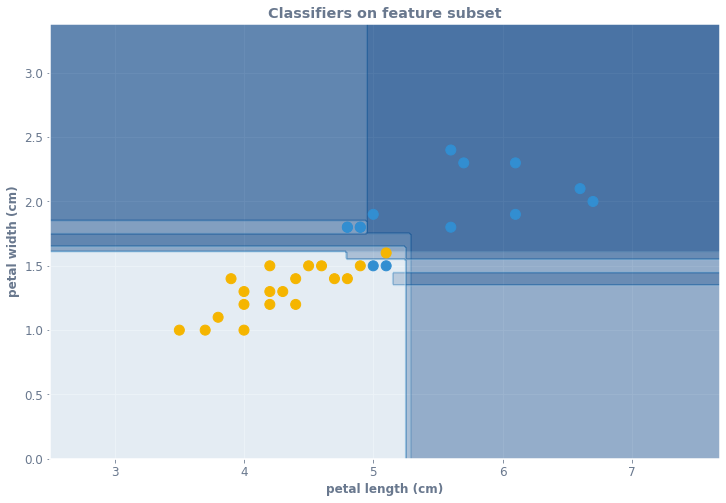

In [60]:
plot_scikit_trees(clf.estimators_)

## Describing Scikit Decision Trees

In [25]:
decision_tree = clf.estimators_[0]

In [26]:
print(decision_tree)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=209652396, splitter='best')


In [27]:
tree = decision_tree.tree_

In [28]:
n_nodes = tree.node_count
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold
print("Node count:", n_nodes)
print("Children left:", children_left)
print("Children right:", children_right)
print("Feature:", feature)
print("Threshold:", threshold)

Node count: 7
Children left: [ 1 -1  3  4 -1 -1 -1]
Children right: [ 2 -1  6  5 -1 -1 -1]
Feature: [ 0 -2  1  0 -2 -2 -2]
Threshold: [ 4.95000005 -2.          1.75        5.29999995 -2.         -2.
 -2.        ]


From [scikit page](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py):

Determining which nodes are leaves.

In [29]:
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

The binary tree structure has 7 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 4.950000047683716 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 1] <= 1.75 else to node 6.
		node=3 test node: go to node 4 if X[:, 0] <= 5.299999952316284 else to node 5.
			node=4 leaf node.
			node=5 leaf node.
		node=6 leaf node.



Traversing the tree and printing out structure.

In [35]:

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)

for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i], # This feature is what needs to be inspected and removed.
                 threshold[i],
                 children_right[i],
                 ))

The binary tree structure has 7 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 4.950000047683716 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 1] <= 1.75 else to node 6.
		node=3 test node: go to node 4 if X[:, 0] <= 5.299999952316284 else to node 5.
			node=4 leaf node.
			node=5 leaf node.
		node=6 leaf node.


## Collapsing Decision Tree

Scikit does not make rebalancing of trees past initialization possible (or at least easy), so for now define own trees and graph method. The Scikit tree object can be found [here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx) in their source code.

In [65]:
class Node(object):
    def __init__(self, data, feature, threshold):
        self.data = data
        self.children = []
        self.feature = feature
        self.threshold = threshold

    def add_child(self, obj):
        self.children.append(obj)

In [ ]:
nodes = 0
for i in 